# OAM computations for circular field using SFA

This jupyter notebook is to compute the OAM of a circular field SFA model with a sin$^2$ pulse.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import functools
import time
from itertools import repeat
from itertools import product

mpl.rcParams['savefig.pad_inches'] = 0

In [ ]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
    
pool = multiprocessing.Pool(processes=cpus)

In [3]:
Pi = np.pi
I = complex(0.,1.)

### Dump File and Pickling

In [4]:
import pickle
import os
DumpFileName = 'OAMDataDump'

In [5]:
def saveDataDump(DataKey, Data, DumpFileName):
    '''Function saves data to file via pickling for easy access and loading'''
    Dics={"Null" : 0}
    #load full database
    if(os.path.exists(DumpFileName)):
        with open(DumpFileName,'rb') as rfp:
            Dics.update(pickle.load(rfp))
            
    #Make new dictionary of data
    OutputDataDict={DataKey : Data}
    #Append new dicitonary to all dictionarys
    Dics.update(OutputDataDict)
    #open file and dump all dicitionarys
    DataDumpFile = open(DumpFileName,'wb')
    pickle.dump(Dics, DataDumpFile)
    DataDumpFile.close()

In [6]:
def loadDataDump(DataKey, DumpFileName):
    '''Function to retrieve data from pickle dump'''
    DataDumpFile = open(DumpFileName,'rb')
    DataOut = pickle.load(DataDumpFile)[DataKey]
    DataDumpFile.close()
    return DataOut

In [7]:
pickleTestData1 = {1,2,3}
pickleTestData2 = {'apple', 'pear', 'banna'}
pickleTestData3 = {2.3, 5.4}

In [8]:
saveDataDump('T1', pickleTestData1, 'pickleTestDump')
saveDataDump('T2', pickleTestData2, 'pickleTestDump')
saveDataDump('T3', pickleTestData3, 'pickleTestDump')

In [9]:
print(loadDataDump('T2', 'pickleTestDump'))

{'apple', 'pear', 'banna'}


## Import SFA Circi Pulse

Here we lad the class that compute the SFA transition amplitude.
It has three class varibles Ip, Up and omega

In [10]:
import SFACircPulse as SFA_CP

### Test SFA Class

In [11]:
#Make class instance
omegaIn = 0.057
IpIn = 0.5
UpIn = 0.44
NIn = 2
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
#make SFA pulse instance
SP = SFA_CP.SFACircularPulse(IpIn, UpIn, omegaIn, NIn)

In [12]:
ps =1.
thetas = Pi/3
phis=Pi/2
#print(SP.S(ps, thetas, phis,ts))
print(SP.S(ps, thetas, phis, ts))
print(SP.DDS(ps, thetas, phis, ts))
times = SP.TimesGen(ps, thetas, phis)#, 4*Pi/omegaIn + I* Pi/(2*omegaIn))
errs=[SP.DS(ps, thetas, phis, ti) for ti in times]
print(times)
print( np.abs(errs)**2)

(2.1025230637548162+23.655988575210912j)
(0.0664015866150167+0.09297079976347679j)
[(43.410345397565784+27.573254372370076j), (135.82179113679268+20.57362290122998j), (206.5774875907038+35.721457033745374j)]
[1.07058594e-29 7.99029815e-30 1.12487128e-28]


In [13]:
Ns = np.array([3, 5, 9])
SPs = np.array([SFA_CP.SFACircularPulse(IpIn, UpIn, omegaIn, Ni) for Ni in Ns])

### Plot Times and Efield

In [14]:
tSample = np.linspace(0., Ns[-1]*2*Pi/omegaIn, 2000)
EfxList = [[SPs[i].Efx(t) for t in tSample]
        for i in range(0,3)]
EfyList = [[SPs[i].Efy(t) for t in tSample]
        for i in range(0,3)]

In [15]:
print(list(SPs[0].TimesGen(0.2, thetas, phis)).sort(key=lambda x: x.real))

None


In [16]:
pList = np.linspace(0.05, 2.6, 250)
pIndx = 50
tList = [
    np.array([np.sort(SPs[i].TimesGen(p, thetas, phis)) for p in pList])
    for i in range(0,3)]
       

E1Pointsx = np.array([
    [SPs[i].Efx(tn.real) 
      #abs(ten.real) < tauEnd(Ns[i]) else None 
     for tn in tList[i][pIndx]]
    for i in range(0,3)])
E1Pointsy = np.array([
    [SPs[i].Efy(tn.real) 
      #abs(ten.real) < tauEnd(Ns[i]) else None 
     for tn in tList[i][pIndx]]
    for i in range(0,3)])

#swap dimension tlist
tList= np.array([[[tListi[j][k] for j in range(0, len(tListi))] 
         for k in range(0, len(tListi[0]))] 
        for tListi in tList])

Mins =[[pList[np.argmin(np.imag(tp))] for tp in tList[i] ] for i in range(0, 3)]

## Compute Momentum Distribusions

In [17]:
dp = 4./500
pxList = np.arange(-1.7, 1.7, dp)
pyList = np.arange(-1.7, 1.7, dp)
pxGrid, pyGrid = np.meshgrid(pxList, pyList)
pz = 0.1
delays = np.array([1, 2, 3])*2*Pi/omegaIn

In [18]:
t1 = time.time()
MGrids = [ np.array(pool.starmap(SPs[i].M_List, zip(pxGrid, pyGrid,  repeat(pz)) ))
          for i in range(0,3)]
t2 = time.time()
print(t2 - t1)

30.55587339401245


In [19]:
MGrids = [np.abs(MGrids[i])**2 for i in range(0,3)]
MMaxs = [np.max(MGrids[i]) for i in range(0,3)]

#### Pickle and Dump

In [20]:
saveDataDump('Times', [tSample, EfxList, EfyList, pList, tList,E1Pointsx,E1Pointsy,pIndx
                      ,MGrids, pxList, pyList, MMaxs, Mins], DumpFileName)

<Figure size 640x480 with 0 Axes>

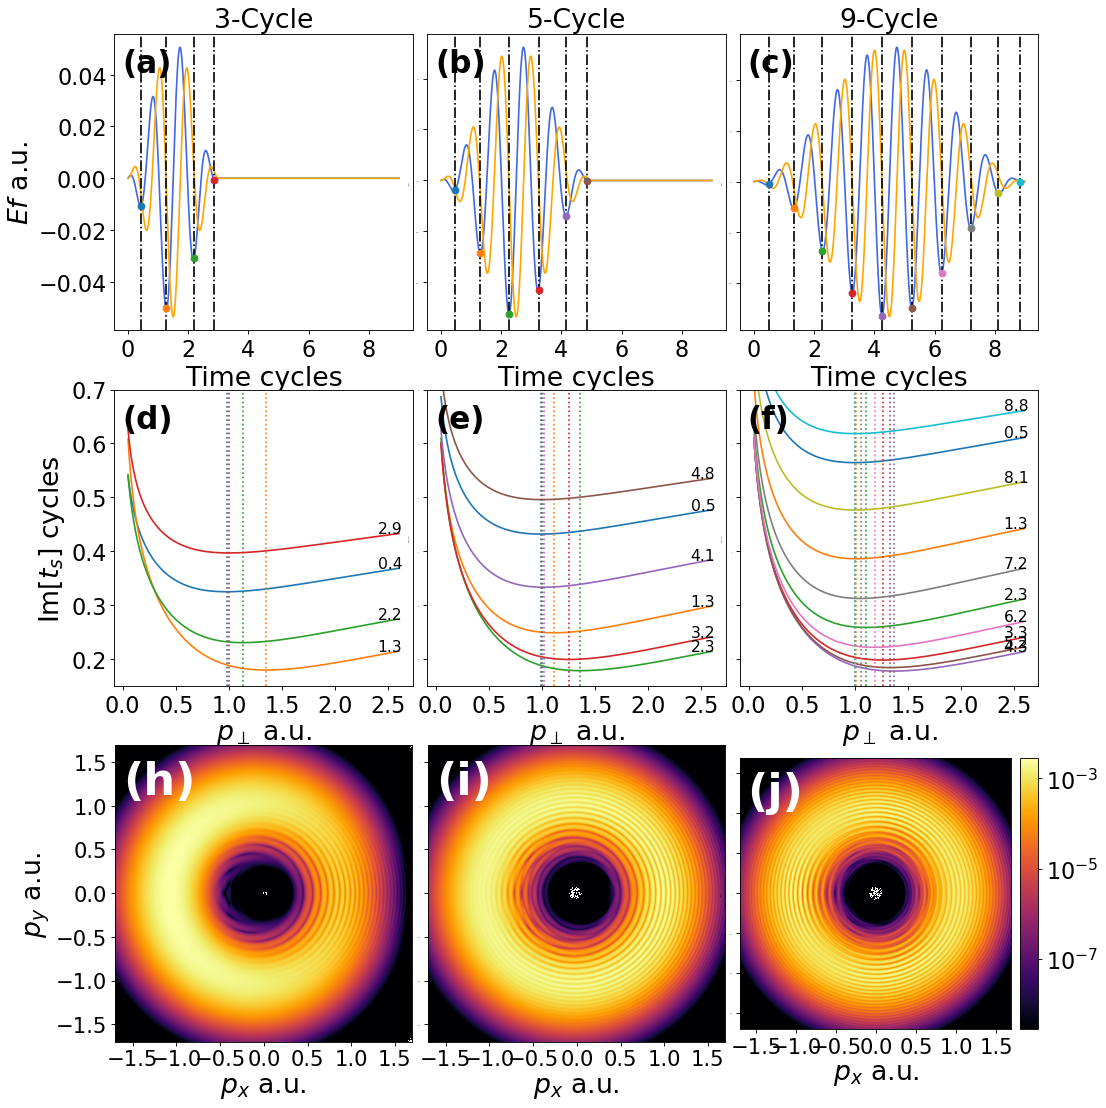

In [21]:
[tSample, EfxList, EfyList, pList, tList,E1Pointsx,E1Pointsy,pIndx
,MGrids, pxList, pyList, MMaxs, Mins] = loadDataDump('Times', DumpFileName)
plt.style.use('default')
dcolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.tight_layout()
#plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)

panelLabels = [['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)'], ['(h)', '(i)', '(j)']]
Titles = [str(Ns[i])+'-Cycle'for i in range(0,3)]

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
# row 1 Efield
for i in range(0, 3):
    ax = plt.subplot(3, 3, i+1)
    ax.text(0.025, 0.95, panelLabels[0][i], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.xlabel('Time cycles', fontsize=24)
    plt.ylabel('$Ef$ a.u.', fontsize= 24 if i==0 else 0)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20 if i==0 else 0)
    plt.gca().set_prop_cycle(None)
    plt.title(Titles[i],{'fontsize':24})
    plt.plot(tSample* omegaIn/(2*Pi), EfxList[i], '-',label='Efx',color='royalblue')
    plt.plot(tSample* omegaIn/(2*Pi), EfyList[i], '-',label='Efy', color='orange')
    #plt.plot(tList[i][:,-1].real, E1Pointsx,'o')
    for j in range(0,len(tList[i])):
        plt.axvline(x=tList[i][j][pIndx].real* omegaIn/(2*Pi),color='black',linestyle='-.')
        plt.plot(tList[i][j][pIndx].real* omegaIn/(2*Pi), E1Pointsx[i][j],'o')
        #plt.plot(tList[i][j][pIndx].real* omegaIn/(2*Pi), E1Pointsy[i][j],'o')
#row 2 imaginary time plot   
#for i in range(0, 3):
    ax = plt.subplot(3, 3, 3+i+1)
    ax.text(0.025, 0.95, panelLabels[1][i], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.ylabel('$\mathrm{Im}[{t_s}]$ cycles', fontsize=24 if i==0 else 0)
    plt.xlabel('$p_{\perp}$ a.u.', fontsize= 24 )
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20 if i==0 else 0)
    plt.gca().set_prop_cycle(None)
    plt.ylim(0.15,0.7)
    
    tLen = len(tList[i])
    for j in range(0,tLen):
        plt.plot(pList,np.array(tList[i][j]).imag * omegaIn/(2*Pi),'-')
        tend = tList[i][j][-1]* omegaIn/(2*Pi)
        plt.text(2.4, tend.imag, "{0:.1f}".format(tend.real),fontsize=(14))
        plt.axvline(x=Mins[i][j], color = dcolours[j],linestyle='dotted')
    plt.gca().set_prop_cycle(None)

#row 3 momentum distribusion
#for i in range(0, 3):
    ax = plt.subplot(3, 3, 6+i+1)
    ax.text(0.025, 0.95, panelLabels[2][i], transform=ax.transAxes,
      fontsize=40, fontweight='bold', va='top', color ='white')
    plt.ylabel('$p_{y}$ a.u.', fontsize=(24 if i==0 else 0))
    plt.xlabel('$p_{x}$ a.u.', fontsize=(24))
    plt.xticks(fontsize=(19))
    plt.yticks(fontsize=(19 if i==0 else 0))
    
    #ax = plt.gca()
    im = ax.imshow(np.flip(MGrids[i],0), extent = (np.amin(pxList), np.amax(pxList), np.amin(pyList), np.amax(pyList)),
              cmap=cm.inferno, norm=LogNorm(vmin=MMaxs[i]*1e-6, vmax=MMaxs[i]), 
                interpolation = 'bicubic', aspect = 1.)

    if(i==2):
        aspect = 15
        pad_fraction = 0.5
        divider = make_axes_locatable(ax)
        width = axes_size.AxesY(ax, aspect=1./aspect)
        pad = axes_size.Fraction(pad_fraction, width)
        cax = divider.append_axes("right", size=width, pad=pad)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=20)

#plt.margins(0.1,0.1)
plt.subplots_adjust(top = 0.975, bottom = 0.075, right = 0.925, left = 0.1, hspace = 0.2, wspace = 0.05)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/Pulse_FieldTimesMom.pdf")

# Computing the OAM

In [22]:
pList = np.linspace(0.4, 1.75, 750)
lList = np.array([l for l in range(20, 41)])

MlList = [
    np.abs(np.array(
        pool.starmap(SPs[i].Ml , zip(pList, repeat(Pi/2), repeat(500)))).T)**2
        #[abs(SPs[i].Ml(p, Pi/2, 100))**2 for p in pList]).T 
    for i in range(0,3)]

KeyboardInterrupt: 

In [ ]:
MlMaxIndex = np.array([[np.argmax(M) for M in Ml] for Ml in MlList])
DiffList = np.array([np.diff(0.5*pList[MlMaxIndex[i][lList]]**2) for i in range(0,3)])

In [ ]:
omegaList = [(1-1/(N*N))*omegaIn if (N % 2)==0 else omegaIn for N in Ns]
shiftList = [0.19, 0.0725, 0.0375]#EvenShifts
peaksMarkerGrid = np.array([np.sqrt(2*(omegaList[i]*lList+shiftList[i]-IpIn-UpIn)) for i in range(0,len(Ns))])
peaksMarkerGridDict = np.array([dict(zip(lList, peaksMarkers)) for peaksMarkers in peaksMarkerGrid])#use for even cycles

In [ ]:
saveDataDump('OAMPulse_Odd', [pList, lList, MlList, peaksMarkerGridDict], DumpFileName)

In [ ]:
[pList, lList, MlList, peaksMarkerGridDict] = loadDataDump('OAMPulse_Even', DumpFileName)

panelLabels = ['(a)', '(b)', '(c)']
oddShifts = [0.02, 0.015, 0.011] #OddShifts
peaksMarkers = [np.sqrt(2*(omegaIn*lList-IpIn-UpIn+s)) for s in oddShifts]
peaksMarkersDict = [dict(zip(lList, p)) for p in peaksMarkers]# use for odd cycles
plt.figure(num=None, figsize=(12, 14), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)
for j in range(0,3):
    ax = plt.subplot(3, 1, j+1)
    ax.text(0.9, 0.95, panelLabels[j], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.ylabel('sig arb.', fontsize=(32))
    plt.xlabel('$E$ a.u.', fontsize=(32 if j==2 else 0))
    plt.xticks(fontsize=(24 if j==2 else 0))
    plt.yticks(fontsize=(24))
    for l in lList:
        plt.plot(0.5*pList**2,MlList[j][l]*1e4,'-',label=str(l))
        peakpos = 0.5*peaksMarkerGridDict[j][l]**2 #0.5*peaksMarkersDict[j][l]**2 #put correct markers for even or odd cycles
        if not (np.isnan(peakpos) or peakpos<0.2 or peakpos>1.2):
            plt.axvline(x=peakpos,color='black',linestyle='-.')
            plt.text(peakpos+0.0025, np.max(MlList[j])*1e4, str(l),fontsize=(12))
        
    if j==0:
        legend = ax.legend(title='OAM l',shadow=True, fontsize='x-large', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.setp(legend.get_title(),fontsize='x-large')
    plt.xlim(0.2, 1.2)
        #ax.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0.075, right = 0.85, left = 0.15, 
            hspace = 0, wspace = 0)
#plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/OAMPulseDistribusions_Even.pdf")

In [ ]:
[pList, lList, MlList, peaksMarkerGridDict] = loadDataDump('OAMPulse_Odd', DumpFileName)

panelLabels = ['(a)', '(b)', '(c)']
oddShifts = [0.02, 0.015, 0.011] #OddShifts
peaksMarkers = [np.sqrt(2*(omegaIn*lList-IpIn-UpIn+s)) for s in oddShifts]
peaksMarkersDict = [dict(zip(lList, p)) for p in peaksMarkers]# use for odd cycles
plt.figure(num=None, figsize=(12, 14), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)
for j in range(0,3):
    ax = plt.subplot(3, 1, j+1)
    ax.text(0.9, 0.95, panelLabels[j], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.ylabel('sig arb.', fontsize=(32))
    plt.xlabel('$E$ a.u.', fontsize=(32 if j==2 else 0))
    plt.xticks(fontsize=(24 if j==2 else 0))
    plt.yticks(fontsize=(24))
    for l in lList:
        plt.plot(0.5*pList**2,MlList[j][l]*1e4,'-',label=str(l))
        peakpos = 0.5*peaksMarkersDict[j][l]**2 #0.5*peaksMarkersDict[j][l]**2 #put correct markers for even or odd cycles
        if not (np.isnan(peakpos) or peakpos<0.2 or peakpos>1.2):
            plt.axvline(x=peakpos,color='black',linestyle='-.')
            plt.text(peakpos+0.0025, np.max(MlList[j])*1e4, str(l),fontsize=(12))
        
    if j==0:
        legend = ax.legend(title='OAM l',shadow=True, fontsize='x-large', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.setp(legend.get_title(),fontsize='x-large')
    plt.xlim(0.2, 1.2)
        #ax.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0.075, right = 0.85, left = 0.15, 
            hspace = 0, wspace = 0)
#plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/OAMPulseDistribusions_Odd.pdf")

In [ ]:
plt.figure(num=None, figsize=(12, 14), dpi=80, facecolor='w', edgecolor='k')
for j in range(0,3):
    plt.plot(lList[1:], DiffList[j],'-',label=str(j))
legend = ax.legend(title='OAM l',shadow=True, fontsize='x-large')

## Plot OAM mono expression

In [ ]:
pList = np.linspace(0.4, 1.75, 1000)
lList = np.array([l for l in range(20, 38)])
SPs[0].Ml_Mono(0.1, Pi/2., lList)
MlList_Mono = [
     np.abs(np.array(
         pool.starmap(SPs[i].Ml_Mono , zip(pList, repeat(Pi/2), repeat(lList)))).T)**2
         #[abs(SPs[i].Ml(p, Pi/2, 100))**2 for p in pList]).T 
     for i in range(0,3)]

In [ ]:
saveDataDump('OAMMono', [pList, lList, MlList_Mono], DumpFileName)

In [ ]:
[pList, lList, MlList_Mono] = loadDataDump('OAMMono', DumpFileName)

panelLabels = ['(a)', '(b)', '(c)']
peaksMarkers = np.sqrt(2*(omegaIn*lList-IpIn-UpIn))
plt.figure(num=None, figsize=(12, 14), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)
for j in range(0,3):
    ax = plt.subplot(3, 1, j+1)
    ax.text(0.9, 0.95, panelLabels[j], transform=ax.transAxes,
      fontsize=28, fontweight='bold', va='top')
    plt.ylabel('$sig. $ a.u.', fontsize=(32))
    plt.yticks(fontsize=(24))
    plt.xlabel('$E $ a.u.', fontsize=(32 if j==2 else 0))
    plt.xticks(fontsize=(24 if j==2 else 0))
    
    for i in range(0, len(lList)):
        plt.plot(0.5*pList**2,MlList_Mono[j][i]*1e3,'-',label=str(lList[i]))
        peakpos = 0.5*peaksMarkers[i]**2
        plt.axvline(x=peakpos,color='black',linestyle='-.')
        plt.text(peakpos+0.01, np.max(MlList_Mono[j][i])*1e3, str(lList[i]),fontsize=(14))
    plt.ylim(0,np.max(MlList_Mono[j])*1e3*1.05)
    plt.xlim(0.2, 1.2)
    if j==0:
        legend = ax.legend(title='OAM l',shadow=True, fontsize='x-large', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.setp(legend.get_title(),fontsize='x-large')
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0.075, right = 0.85, left = 0.15, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/OAMPulseDistribusions_Mono.pdf")

# Analytical OAM results

### Plot Integrand

In [ ]:
tIn = 1.75*Pi/omegaIn
pList = np.linspace(0.05, 10., 5000)
OAMIntList1 = [np.array([SPs[i].OAM_IntegrandIm(tIn, p, Pi/2, 30) for p in pList]) for i in range(0,3)]

pIn = 1.75
tList = np.linspace(0.05, 6., 5000)*2*Pi/omegaIn
OAMIntList2 = [np.array([SPs[i].OAM_IntegrandIm(t, pIn, Pi/2, 30).real for t in tList]) for i in range(0,3)]
#OAMIntList2 = [np.array([SPs[i].Af2I(t) for t in tList]) for i in range(0,3)]

In [ ]:
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
ax = plt.subplot(1, 2, 1)
for j in range(0,3):
    plt.plot(pList,OAMIntList1[j],'-')
ax = plt.subplot(1, 2, 2)
for j in range(0,3):
    plt.plot(tList,OAMIntList2[j],'-')

### Plot OAM

In [ ]:
pList = np.linspace(0.25, 1.75, 500)
lList = [l for l in range(1, 44)]
OAMMList =np.array([
    pool.starmap(SPs[i].OAM_M_List , zip(repeat(pList), repeat(Pi/2), lList, repeat(1e-8), repeat(5000))) 
    for i in range(0,3)])

In [ ]:
#maxes = [0.00012,0.00035,0.00065]

plt.figure(num=None, figsize=(18, 21), dpi=80, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
for j in range(0,3):
    ax = plt.subplot(3, 1, j+1)
    for l in range(0,len(lList)):
        plt.plot(pList,OAMMList[j,l],'-')
        #plt.ylim(0,maxes[j])

In [ ]:
pList = np.linspace(0.25, 1.75, 500)
lList = [l for l in range(20, 44)]
OAMMList =np.array([
    pool.starmap(SPs[i].OAM_M_List , zip(repeat(pList), repeat(Pi/2), lList, repeat(1e-8), repeat(5000))) 
    for i in range(0,3)])